In [1]:
import tensorflow as tf

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import math
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", tf.keras.__version__)
print("Tensorflow: ", tf.__version__)


Python:  3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
pandas:  0.25.1
numpy:  1.17.2
seaborn:  0.9.0
matplotlib:  3.1.1
sklearn:  0.21.3
Keras:  2.2.4-tf
Tensorflow:  2.0.0-rc1


In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
dataframe = pd.read_csv('data/nyc_taxi.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')


In [3]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [4]:

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 8
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


In [5]:
# create and fit the LSTM network
batch_size = 1
model = tf.keras.Sequential()
model.add( tf.keras.layers.LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=['mse', 'accuracy', 'binary_accuracy'])
for i in range(5):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
	model.reset_states()


Train on 6903 samples
6903/6903 [==============================] - 42s 6ms/sample - loss: 0.0069 - mse: 0.0069 - accuracy: 0.0000e+00 - binary_accuracy: 0.0000e+00
Train on 6903 samples
6903/6903 [==============================] - 38s 6ms/sample - loss: 0.0012 - mse: 0.0012 - accuracy: 0.0000e+00 - binary_accuracy: 0.0000e+00
Train on 6903 samples
6903/6903 [==============================] - 37s 5ms/sample - loss: 0.0011 - mse: 0.0011 - accuracy: 0.0000e+00 - binary_accuracy: 0.0000e+00
Train on 6903 samples
6903/6903 [==============================] - 38s 6ms/sample - loss: 0.0010 - mse: 0.0010 - accuracy: 0.0000e+00 - binary_accuracy: 0.0000e+00
Train on 6903 samples
6903/6903 [==============================] - 38s 6ms/sample - loss: 0.0010 - mse: 0.0010 - accuracy: 0.0000e+00 - binary_accuracy: 0.0000e+00


In [6]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [7]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 1381.11 RMSE
Test Score: 1374.39 RMSE


In [8]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


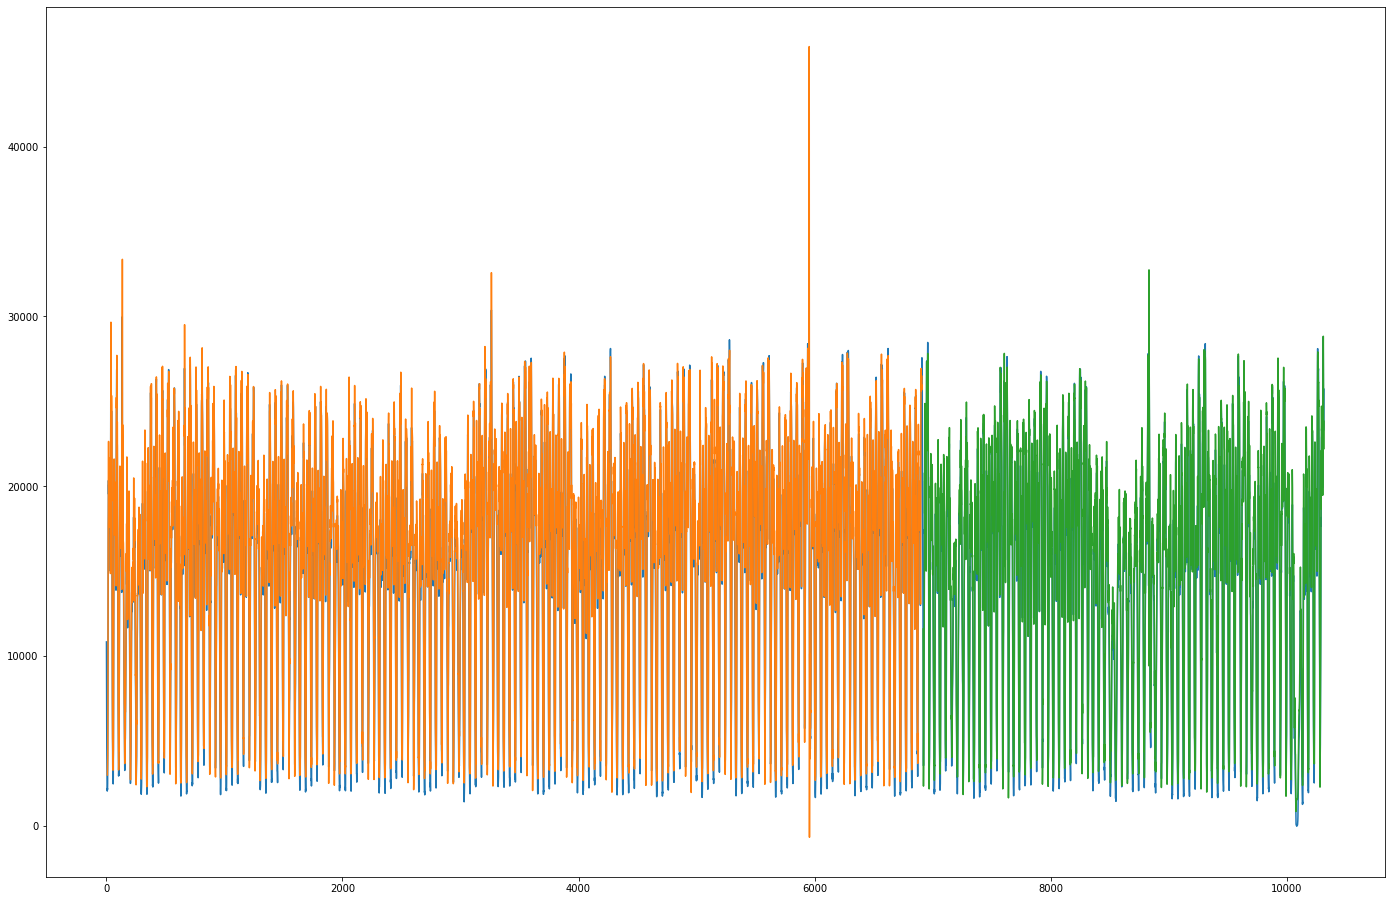

In [9]:
# plot baseline and predictions
plt.figure(figsize=(24,16))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Text(0.5, 1.0, 'Time Series of value by date time')

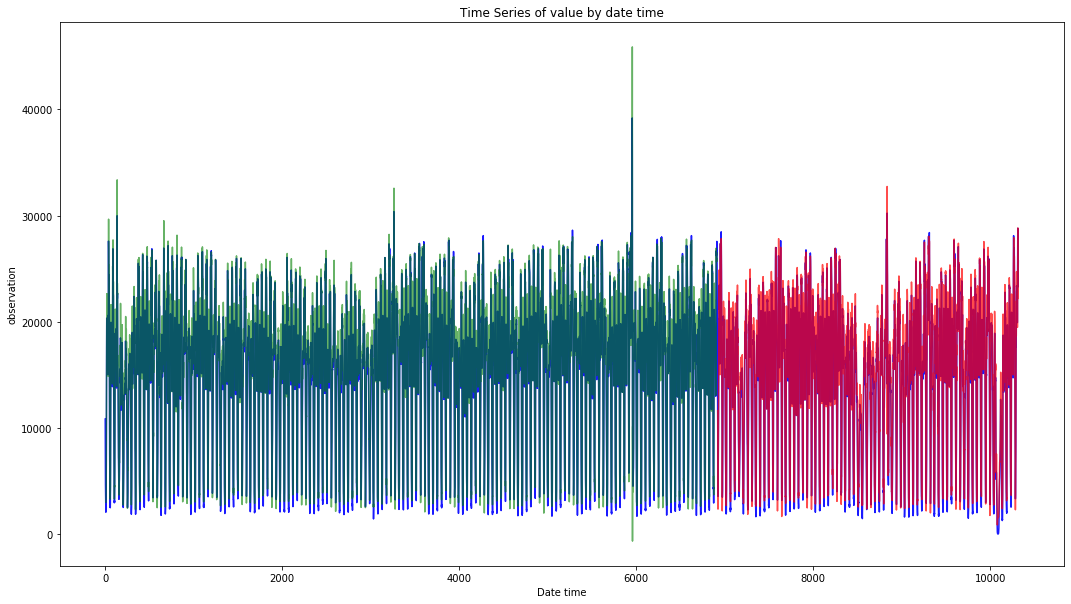

In [10]:
figure, axes = plt.subplots(figsize=(18, 10))
axes.plot(scaler.inverse_transform(dataset), color='b', alpha=0.9)
axes.plot(trainPredictPlot, color='g', alpha=0.6)
axes.plot(testPredictPlot, color='r', alpha=0.7)
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')